In [27]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('womens_matchups.csv')
df = df[df['round'] == 'First Round']
print(df.shape)
df.head()

(128, 27)


,year,region,round,high_bracket_seed,high_team_id,low_bracket_seed,low_team_id,win,adj_oe,adj_de,...,ftr,ftrd,2p%,2p%d,3p%,3p%d,3pr,3prd,adj_tempo,wab
0,2021,East,First Round,1,2021 Stanford,16,2021 Utah Valley,1,15.9000,40.3000,...,-0.4000,-6.1000,11.0000,-10.9000,5.4000,-3.9000,3.4000,0.3000,4.9000,17.0000
10,2021,East,First Round,8,2021 Oklahoma St.,9,2021 Wake Forest,1,-8.7000,15.8000,...,2.1000,-9.1000,-1.1000,-7.3000,2.7000,2.4000,-3.6000,-0.2000,3.5000,3.1000
11,2021,East,First Round,5,2021 Missouri St.,12,2021 UC Davis,1,-14.1000,23.1000,...,5.9000,0.2000,9.5000,-3.6000,5.0000,-7.0000,-6.5000,-4.2000,2.6000,3.9400
13,2021,East,First Round,4,2021 Arkansas,13,2021 Wright St.,0,4.2000,15.6000,...,1.7000,-4.0000,7.5000,3.6000,12.7000,6.4000,2.5000,5.2000,8.3000,8.6000
14,2021,East,First Round,6,2021 Oregon,11,2021 South Dakota,1,-0.2000,12.4000,...,-11.1000,-6.0000,10.6000,-9.0000,-0.3000,-2.4000,-4.6000,-0.4000,0.7000,3.9400


In [28]:
df['win'].value_counts(normalize=True)

1   0.8516
0   0.1484
Name: win, dtype: float64

In [29]:
df.columns

Index(['year', 'region', 'round', 'high_bracket_seed', 'high_team_id',
       'low_bracket_seed', 'low_team_id', 'win', 'adj_oe', 'adj_de', 'barthag',
       'efg%', 'efgd%', 'tor', 'tord', 'orb%', 'drb%', 'ftr', 'ftrd', '2p%',
       '2p%d', '3p%', '3p%d', '3pr', '3prd', 'adj_tempo', 'wab'],
      dtype='object')

In [30]:
eda_df = df[[
    'win',
    'adj_oe', 
    'adj_de', 
    'barthag',
    'efg%', 
    'efgd%', 
    'tor', 
    'tord', 
    'orb%', 
    'drb%', 
    'ftr', 
    'ftrd',
    '2p%', 
    '2p%d', 
    '3p%', 
    '3p%d', 
    '3pr', 
    '3prd', 
    'adj_tempo', 
    'wab']]

In [31]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(89, 20)
(39, 20)


### I. Numerical Tests

In [32]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 10]
print(correlation_with_target)

adj_oe     19.8800
adj_de     27.6100
barthag    31.9600
efgd%      14.2000
tord       18.6800
drb%       20.6300
ftrd       20.9400
2p%d       13.2800
3pr        12.0200
3prd       23.9600
wab        29.0800
win       100.0000
Name: win, dtype: float64


In [33]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,adj_oe,3.5816,0.0617,0.0259
1,adj_de,7.1777,0.0088,0.1103
2,barthag,9.8968,0.0023,0.0600
3,efg%,0.0091,0.9243,0.0000
4,efgd%,1.7899,0.1844,0.0000
5,tor,0.2794,0.5984,0.0203
6,tord,3.1468,0.0796,0.0200
7,orb%,0.0081,0.9283,0.0100
8,drb%,3.8677,0.0524,0.0000
9,ftr,0.1520,0.6976,0.0000


In [34]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
1,adj_de,7.1777,0.0088,0.1103
2,barthag,9.8968,0.0023,0.0600
18,wab,8.0385,0.0057,0.1434


In [35]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
1,adj_de,7.1777,0.0088,0.1103
2,barthag,9.8968,0.0023,0.0600
10,ftrd,3.9891,0.0489,0.0000
16,3prd,5.2976,0.0237,0.0052
18,wab,8.0385,0.0057,0.1434


In [36]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
1,adj_de,7.1777,0.0088,0.1103
2,barthag,9.8968,0.0023,0.0600
16,3prd,5.2976,0.0237,0.0052
18,wab,8.0385,0.0057,0.1434


### II. Wrapper Methods

In [37]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [38]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [39]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 19
selected features: 10
features with coefficients shrank to zero: 9


In [40]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.91
Lasso Regression F1 Score (Test): 0.93


In [41]:
selected_feat

Index(['adj_de', 'barthag', 'efg%', 'tor', 'tord', 'drb%', 'ftrd', '3p%',
       '3pr', '3prd'],
      dtype='object')

In [42]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [43]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [44]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['adj_de', 'efg%', 'efgd%', 'tord', 'drb%', '2p%', '3p%', '3pr',
       '3prd', 'adj_tempo'], dtype=object)

In [45]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9942857142857142
Test set
Random Forests roc-auc: 0.35882352941176476


In [46]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9971428571428572
Test set
Random Forests roc-auc: 0.5235294117647059


In [47]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5411764705882353,
 0.4264705882352941,
 0.5411764705882353,
 0.35294117647058826,
 0.5411764705882354,
 0.738235294117647,
 0.38235294117647056,
 0.4264705882352941,
 0.5029411764705882,
 0.6264705882352941,
 0.49999999999999994,
 0.47352941176470587,
 0.7235294117647059,
 0.38235294117647056,
 0.5088235294117647,
 0.4558823529411765,
 0.5264705882352941,
 0.5205882352941176,
 0.6558823529411764]

Text(0, 0.5, 'roc-auc')

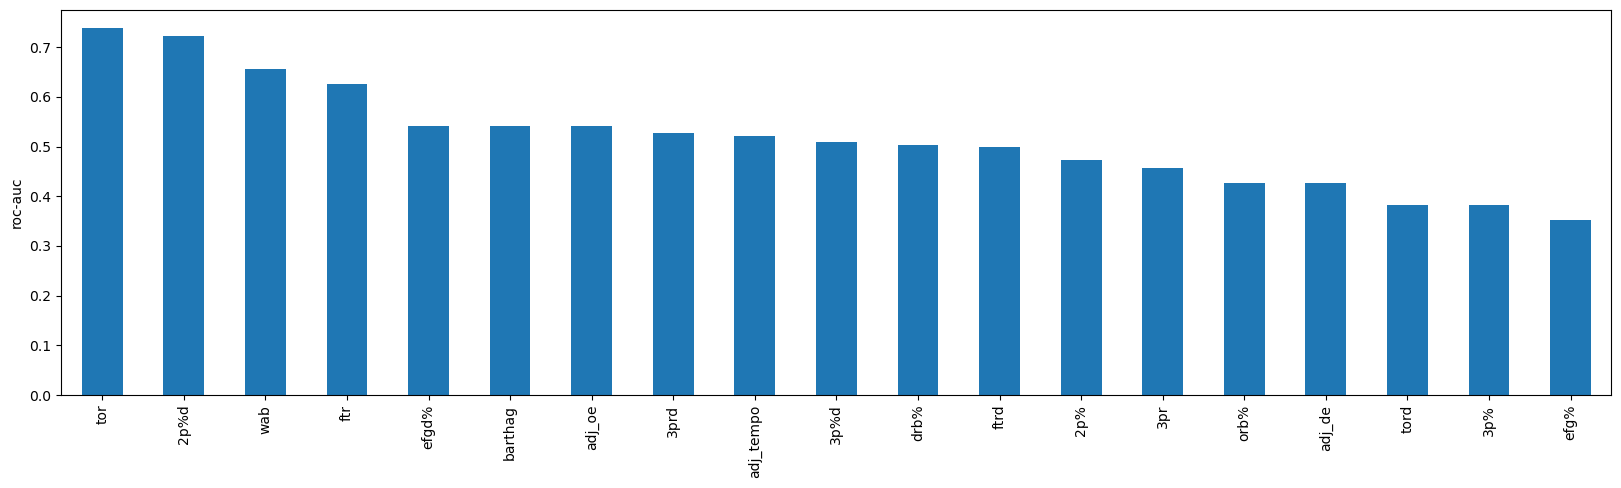

In [48]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [49]:
len(roc_values[roc_values > 0.6])

4

In [50]:
roc_values[roc_values > 0.6]

tor    0.7382
ftr    0.6265
2p%d   0.7235
wab    0.6559
dtype: float64

In [53]:
roc_values[roc_values > 0.54]

adj_oe    0.5412
barthag   0.5412
efgd%     0.5412
tor       0.7382
ftr       0.6265
2p%d      0.7235
wab       0.6559
dtype: float64

In [52]:
roc_values[roc_values > 0.5]

adj_oe      0.5412
barthag     0.5412
efgd%       0.5412
tor         0.7382
drb%        0.5029
ftr         0.6265
2p%d        0.7235
3p%d        0.5088
3prd        0.5265
adj_tempo   0.5206
wab         0.6559
dtype: float64

# III. XGBoost

In [54]:
X_train_scaled2 = X_train_scaled[[
 'adj_oe',
 'barthag',
 'efgd%',
 'tor',
 'drb%',
 'ftr',
 '2p%d',
 '3prd',
 'wab'
]]

X_test_scaled2 = X_test_scaled[[
 'adj_oe',
 'barthag',
 'efgd%',
 'tor',
 'drb%',
 'ftr',
 '2p%d',
 '3prd',
 'wab'
]]

In [55]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.3, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 300, 'subsample': 0.4}


In [56]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.2, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [57]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.33401566281507183


In [58]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.92
F1 Score on Test Data: 0.93


<Figure size 1000x600 with 0 Axes>

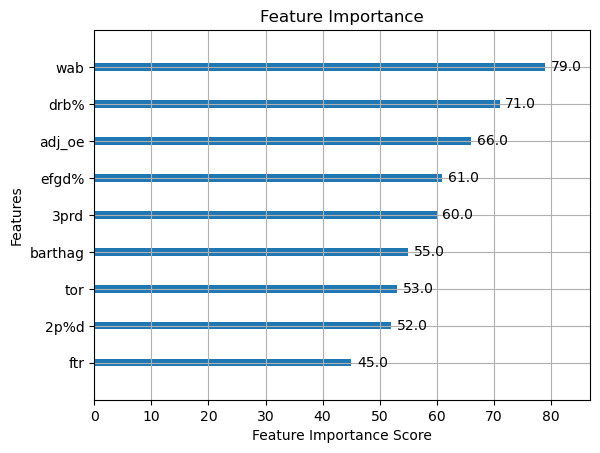

In [59]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()